In [1]:
import time
notebookstart = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from math import sqrt

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

/home/vishy/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
NFOLDS = 5
SEED = 42
VALID = True

path = '/home/vishy/Desktop/Kaggle/Avito/Data/'
subpath = '/home/vishy/Desktop//Kaggle/Avito/Submissions/'

print("Data:\n",os.listdir(path))

Data:
 ['train.csv', 'periods_train.csv', 'periods_test.csv', 'train_active.csv', 'test_active.csv', 'train_jpg', 'image_features', 'aggregated_features.csv', 'sample_images', 'test.csv', 'test_jpg']


In [3]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

In [4]:
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [5]:
import pymorphy2
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(word.lower() for word in textProc.split())
        textProc = " ".join(pymorphy2.MorphAnalyzer().parse(unicode(word))[0].normal_form for word in textProc.split())
        #textProc = textProc.encode("utf-8")
        
        #text = " ".join(word.lower() for word in text.split()) #lowercasing and removing short words 
        #text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #deleting newlines and line-breaks
        #text = re.sub('[.,:;%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #deleting symbols  
        #text = " ".join(pymorphy2.MorphAnalyzer().parse(unicode(word))[0].normal_form for word in text.split())
        #text = text.encode("utf-8")
        
        return textProc
    except:
        return "name error"

In [6]:
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [5]:
print("\nData Load Stage")
training = pd.read_csv(path+'train.csv',index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv(path+'test.csv',index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index

ntrain = training.shape[0]
ntest = testing.shape[0]

cat_cols=['category_name', 'image_top_1']
num_cols=['price', 'deal_probability']

for c in cat_cols:
    for c2 in num_cols:
        enc = training.groupby(c)[c2].agg(['median']).astype(np.float32).reset_index()
        enc.columns = ['_'.join([str(c),str(c2),str(c3)]) if c3 != c else c for c3 in enc.columns]

        training = pd.merge(training, enc, how='left', on=c)
        testing = pd.merge(testing, enc, how='left', on=c)

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))


Data Load Stage
Train shape: 1503424 Rows, 20 Columns
Test shape: 508438 Rows, 20 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 20 Columns


In [7]:
training.isnull().sum()

user_id                                       0
region                                        0
city                                          0
parent_category_name                          0
category_name                                 0
param_1                                   61576
param_2                                  654542
param_3                                  862565
title                                         0
description                              116276
price                                     85362
item_seq_number                               0
activation_date                               0
user_type                                     0
image                                    112588
image_top_1                              112588
category_name_price_median                    0
category_name_deal_probability_median         0
image_top_1_price_median                 112588
image_top_1_deal_probability_median      112588
dtype: int64

In [16]:
training['descnull'] = np.where(training['param_2']==NaN, 1, 0)

NameError: name 'NaN' is not defined

In [15]:
training.head(100)

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,item_seq_number,activation_date,user_type,image,image_top_1,category_name_price_median,category_name_deal_probability_median,image_top_1_price_median,image_top_1_deal_probability_median,descnull
0,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",...,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,1500.0,0.00000,1200.0,0.00000,0
1,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,3000.0,0.00000,4000.0,0.00000,0
2,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",...,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,2000.0,0.00000,4990.0,0.00000,0
3,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,1500.0,0.00000,2000.0,0.11151,0
4,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,237000.0,0.15342,165000.0,0.23044,0
5,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,...,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,1500.0,0.00000,2000.0,0.11151,0
6,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,...,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,2000.0,0.00000,1995.0,0.00000,0
7,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,...,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,900.0,0.00000,500.0,0.00000,0
8,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,...,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,900.0,0.00000,450.0,0.00000,0
9,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,...,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,500.0,0.00000,500.0,0.00000,0


In [ ]:
df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

In [10]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,category_name_price_median
0,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,1500.0
1,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,3000.0
2,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,2000.0
3,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,1500.0
4,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,230000.0


KeyError: 'Column not found: deal_probability'

In [15]:
df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

In [16]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
item_id,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,кокоби(кокон для сна),"кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,стойка для одежды,"стойка для одежды, под вешалки. с бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,philips bluray,"в хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,автокресло,продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ваз 2110, 2003",все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0


In [ ]:
df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

In [ ]:
df.head()

In [8]:
df.isnull().sum()

user_id                     0
region                      0
city                        0
parent_category_name        0
category_name               0
param_1                  3288
param_2                 35801
param_3                 47124
title                       0
description              3907
price                    4729
item_seq_number             0
activation_date             0
user_type                   0
image                    6243
image_top_1              6243
dtype: int64

In [9]:
train_top1 = pd.read_csv(path+'train_image_top_1_features.csv')
test_top1 = pd.read_csv(path+'test_image_top_1_features.csv')
top1_df = pd.concat([train_top1,test_top1],axis=0)
df = df.reset_index()
df = df.merge(top1_df,how = 'left', on='item_id')
df['image_top_1'] = df['image_top_1_y']
del train_top1, test_top1, top1_df, df['image_top_1_x'], df['image_top_1_y']
gc.collect()
print(df.shape)

(80000, 17)


In [10]:
df.isnull().sum()

item_id                     0
user_id                     0
region                      0
city                        0
parent_category_name        0
category_name               0
param_1                  3288
param_2                 35801
param_3                 47124
title                       0
description              3907
price                    4729
item_seq_number             0
activation_date             0
user_type                   0
image                    6243
image_top_1               579
dtype: int64

In [11]:
agg_feats = pd.read_csv(path+'aggregated_features.csv')
df = df.merge(agg_feats,how = 'left', on='user_id')
print(df.shape)

(80000, 20)


In [12]:
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,NaN,NaN,1


In [13]:
df = df.set_index('item_id')

In [14]:
#v4
print("Feature Engineering")
#df["price"] = np.log(df["price"]+0.001)
#df["price"].fillna(df.price.mean(),inplace=True)
#df["image_top_1"].fillna(-999,inplace=True)

#v5
df["price"] = df.groupby(['city','category_name'])['price'].transform(lambda x: x.fillna(x.median()))
df["price"] = np.log(df["price"]+0.001)

#df["image_top_1"] = df.groupby(['city','category_name'])['image_top_1'].transform(lambda x: x.fillna(x.mode()))
df["image_top_1"].fillna(-999,inplace=True)
df['image'] = df['image'].map(lambda x: 1 if len(str(x)) >0 else 0)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

Feature Engineering

Create Time Variables


In [15]:
df.isnull().sum()

user_id                     0
region                      0
city                        0
parent_category_name        0
category_name               0
param_1                  3288
param_2                 35801
param_3                 47124
title                       0
description              3907
price                     732
item_seq_number             0
activation_date             0
user_type                   0
image                       0
image_top_1                 0
avg_days_up_user        18648
avg_times_up_user       18648
n_user_items                0
Weekday                     0
Weekd of Year               0
Day of Month                0
dtype: int64

In [16]:
df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,...,activation_date,user_type,image,image_top_1,avg_days_up_user,avg_times_up_user,n_user_items,Weekday,Weekd of Year,Day of Month
item_id,,,,,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",...,2017-03-28,Private,1,1008.0,8.000000,2.000000,2,1,13,28
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",...,2017-03-26,Private,1,692.0,NaN,NaN,1,6,12,26
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",...,2017-03-20,Private,1,3032.0,4.428571,1.142857,9,0,12,20
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,...,2017-03-25,Company,1,796.0,16.714286,2.642857,32,5,12,25
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,...,2017-03-16,Private,1,2264.0,NaN,NaN,1,3,11,16


In [17]:
df['avg_days_up_user']=df.avg_days_up_user.fillna(0)
df['avg_times_up_user']=df.avg_times_up_user.fillna(0)
df['n_user_items']=df.avg_days_up_user.fillna(1)

In [18]:
"""
# v5
df1  = pd.concat([training,testing],axis=0)
df1 = df1.reset_index()
del training, testing
gc.collect()
del df1['image'], df1['image_top_1']
gc.collect()
train_Active = pd.read_csv(path+'train_active.csv', parse_dates = ["activation_date"],nrows=50000)
test_Active = pd.read_csv(path+'test_active.csv', parse_dates = ["activation_date"],nrows=50000)
fullactive = pd.concat([df1,train_Active,test_Active],axis=0)
fullactive = fullactive[pd.notnull(fullactive['activation_date'])]
print(fullactive.shape)
del df1,train_Active,test_Active
gc.collect()

#fullactive['Day of Month'] = pd.to_datetime(fullactive.activation_date).dt.day.astype('uint8')
fullactive['Weekd of Year'] = pd.to_datetime(fullactive.activation_date).dt.week.astype('uint8')
fullactive['Weekday']  = pd.to_datetime(fullactive.activation_date).dt.weekday.astype('uint8')
print(fullactive.shape)"""

'\n# v5\ndf1  = pd.concat([training,testing],axis=0)\ndf1 = df1.reset_index()\ndel training, testing\ngc.collect()\ndel df1[\'image\'], df1[\'image_top_1\']\ngc.collect()\ntrain_Active = pd.read_csv(path+\'train_active.csv\', parse_dates = ["activation_date"],nrows=50000)\ntest_Active = pd.read_csv(path+\'test_active.csv\', parse_dates = ["activation_date"],nrows=50000)\nfullactive = pd.concat([df1,train_Active,test_Active],axis=0)\nfullactive = fullactive[pd.notnull(fullactive[\'activation_date\'])]\nprint(fullactive.shape)\ndel df1,train_Active,test_Active\ngc.collect()\n\n#fullactive[\'Day of Month\'] = pd.to_datetime(fullactive.activation_date).dt.day.astype(\'uint8\')\nfullactive[\'Weekd of Year\'] = pd.to_datetime(fullactive.activation_date).dt.week.astype(\'uint8\')\nfullactive[\'Weekday\']  = pd.to_datetime(fullactive.activation_date).dt.weekday.astype(\'uint8\')\nprint(fullactive.shape)'

In [19]:
#v5
#fullactive.head()

In [20]:
#v5
#print('grouping by Region-City-Day-Category combination....')
#gp_cnt_day = fullactive[['item_id','region','Weekd of Year','parent_category_name','category_name','price']].groupby(by=['region','Weekd of Year','parent_category_name','category_name'])[['item_id']].count().reset_index().rename(index=str, columns={'item_id': 'gp_cnt_day'})
#gp_avg_day = fullactive[['item_id','region','Weekd of Year','parent_category_name','category_name','price']].groupby(by=['region','Weekd of Year','parent_category_name','category_name'])[['price']].mean().reset_index().rename(index=str, columns={'price': 'gp_avg_day'})

In [21]:
#v5
#gp_cnt_day
#gp_avg_day.head()

In [22]:
#v5
#df.head()

In [23]:
#v5
#df = df.reset_index()

In [24]:
#df.head()

In [25]:
#v5
"""
print('Before:', df.shape)
df = df.merge(gp_cnt_day, on=['region','Weekd of Year','parent_category_name','category_name'], how='left')
df = df.merge(gp_avg_day, on=['region','Weekd of Year','parent_category_name','category_name'], how='left')
print('After:', df.shape)

print('grouping by Region-City-Week Day-Category combination....')
gp_cnt_wday = fullactive[['region','city','wday','parent_category_name','category_name','price']].groupby(by=['region','city','wday','parent_category_name','category_name'])[['price']].count().reset_index().rename(index=str, columns={'price': 'qty'})
gp_avg_wday = fullactive[['region','city','wday','parent_category_name','category_name','price']].groupby(by=['region','city','wday','parent_category_name','category_name'])[['price']].mean().reset_index().rename(index=str, columns={'price': 'avg'})
df = df.merge(gp_cnt_wday, on=['region','city','wday','parent_category_name','category_name'], how='left')
df = df.merge(gp_avg_wday, on=['region','city','wday','parent_category_name','category_name'], how='left')


#del gp_cnt_day, gp_avg_day
#del gp_cnt_wday, gp_avg_wday"""

"\nprint('Before:', df.shape)\ndf = df.merge(gp_cnt_day, on=['region','Weekd of Year','parent_category_name','category_name'], how='left')\ndf = df.merge(gp_avg_day, on=['region','Weekd of Year','parent_category_name','category_name'], how='left')\nprint('After:', df.shape)\n\nprint('grouping by Region-City-Week Day-Category combination....')\ngp_cnt_wday = fullactive[['region','city','wday','parent_category_name','category_name','price']].groupby(by=['region','city','wday','parent_category_name','category_name'])[['price']].count().reset_index().rename(index=str, columns={'price': 'qty'})\ngp_avg_wday = fullactive[['region','city','wday','parent_category_name','category_name','price']].groupby(by=['region','city','wday','parent_category_name','category_name'])[['price']].mean().reset_index().rename(index=str, columns={'price': 'avg'})\ndf = df.merge(gp_cnt_wday, on=['region','city','wday','parent_category_name','category_name'], how='left')\ndf = df.merge(gp_avg_wday, on=['region','ci

In [26]:
#df.head()

In [27]:
#v5
#df = df.set_index('item_id')
#print(df.shape)
#df.head()

In [28]:
#df["gp_avg_day"] = np.log(df["gp_avg_day"]+0.001)

In [29]:
# v4
# Create Validation Index and Remove Dead Variables
# training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
# validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
# df.drop(["activation_date","image"],axis=1,inplace=True)
# v5
df.drop(["activation_date",],axis=1,inplace=True)

In [30]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name",
               "user_type","image_top_1",'image',"param_1","param_2","param_3"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'image', 'param_1', 'param_2', 'param_3']


In [31]:
print(df.shape)#,ready_df.shape)

(80000, 21)


In [32]:
print("\nText Features")

# Feature Engineering

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if
                                          c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str)
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}

def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])

start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)


Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 0.20 Minutes


In [33]:
ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,'max_iter':None, 
                'tol':0.001, 'solver':'auto', 'random_state':SEED}
#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
        
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])
rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.24024710003506589


In [34]:
print("Modeling Stage")
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
df['ridge_preds'] = ridge_preds

Modeling Stage


In [35]:
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

50000 Rows and 140794 Cols
30000 Rows and 140794 Cols
Feature Names Length:  140794


In [46]:
#from sklearn.model_selection import KFold
#kfold  =  KFold(n_splits=NFOLDS, shuffle=True,random_state=SEED)

In [37]:
#print('X train:', X.shape)
#print('X test: ', testing.shape)
#print('y train:', y.shape)

X train: (50000, 140794)
X test:  (30000, 140794)
y train: (50000,)


In [41]:
#y_test_pred = np.zeros(((testing.shape[0]), NFOLDS))
#print(y_test_pred.shape)

(30000, 5)


In [43]:
#cv_scores  = []

In [48]:
"""
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X, y)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X[ix_train]
    X_fold_val = X[ix_val]

    y_fold_train = y[ix_train]
    y_fold_val = y[ix_val]
    
    lgbm_params =  {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse',# 'max_depth': 15,
                    'num_leaves': 400,'feature_fraction': 0.5,'bagging_fraction': 0.75,# 'bagging_freq': 5,
                    'learning_rate': 0.018, 'verbose': 1 }
    
    lgtrain = lgb.Dataset(X_fold_train, y_fold_train,feature_name=tfvocab,categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_fold_val, y_fold_val,feature_name=tfvocab,categorical_feature = categorical)
    evals_result = {}
    
    lgb_clf = lgb.train(lgbm_params,lgtrain,num_boost_round=20000,valid_sets=[lgtrain, lgvalid],
                        early_stopping_rounds=50,verbose_eval=100) #valid_names=['train','valid'],
    
    fold_train_scores = evals_result['training'][lgbm_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgbm_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(fold_num + 1,len(fold_train_scores), fold_train_scores[-1],fold_val_scores[-1],))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    y_test_pred[:, fold_num] = lgb_clf.predict(X_test).reshape(-1)
"""

"\n%%time\n\nfor fold_num, (ix_train, ix_val) in enumerate(kfold.split(X, y)):\n    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')\n    \n    X_fold_train = X[ix_train]\n    X_fold_val = X[ix_val]\n\n    y_fold_train = y[ix_train]\n    y_fold_val = y[ix_val]\n    \n    lgbm_params =  {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse',# 'max_depth': 15,\n                    'num_leaves': 400,'feature_fraction': 0.5,'bagging_fraction': 0.75,# 'bagging_freq': 5,\n                    'learning_rate': 0.018, 'verbose': 1 }\n    \n    lgtrain = lgb.Dataset(X_fold_train, y_fold_train,feature_name=tfvocab,categorical_feature = categorical)\n    lgvalid = lgb.Dataset(X_fold_val, y_fold_val,feature_name=tfvocab,categorical_feature = categorical)\n    evals_result = {}\n    \n    lgb_clf = lgb.train(lgbm_params,lgtrain,num_boost_round=20000,valid_sets=[lgtrain, lgvalid],\n                        early_stopping_rounds=50,verbose_eval=100) #valid_names

In [ ]:
#print('Final CV score:', np.mean(cv_scores))

In [ ]:
#y_test = np.mean(y_test_pred, axis=1)

In [36]:
print("\nModeling Stage")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)

#del ridge_preds,vectorizer,ready_df
gc.collect();

print("Light Gradient Boosting Regressor")
lgbm_params =  {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse',# 'max_depth': 15,
                'num_leaves': 1000,'feature_fraction': 0.5,'bagging_fraction': 0.75,# 'bagging_freq': 5,
                'learning_rate': 0.018, 'verbose': 1 }


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)

    # LGBM Dataset Formatting
lgtrain = lgb.Dataset(X_train, y_train,feature_name=tfvocab,categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,feature_name=tfvocab,categorical_feature = categorical)
del X, X_train; gc.collect()

    # Go Go Go
lgb_clf = lgb.train(lgbm_params,lgtrain,num_boost_round=20000,valid_sets=[lgtrain, lgvalid],
                    valid_names=['train','valid'],early_stopping_rounds=50,verbose_eval=100)
print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
del X_valid ; gc.collect()


Modeling Stage
Light Gradient Boosting Regressor


/home/vishy/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1038: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/vishy/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:683: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.221086	valid's rmse: 0.225281
[200]	train's rmse: 0.213349	valid's rmse: 0.221302
[300]	train's rmse: 0.209024	valid's rmse: 0.220076
[400]	train's rmse: 0.2057	valid's rmse: 0.219413
[500]	train's rmse: 0.203059	valid's rmse: 0.219013
[600]	train's rmse: 0.200798	valid's rmse: 0.218767
[700]	train's rmse: 0.198851	valid's rmse: 0.218564
[800]	train's rmse: 0.197011	valid's rmse: 0.218444
[900]	train's rmse: 0.195453	valid's rmse: 0.218367
[1000]	train's rmse: 0.194022	valid's rmse: 0.218306
[1100]	train's rmse: 0.192684	valid's rmse: 0.218265
[1200]	train's rmse: 0.191414	valid's rmse: 0.21823
[1300]	train's rmse: 0.190284	valid's rmse: 0.218203
[1400]	train's rmse: 0.189163	valid's rmse: 0.218182
Early stopping, best iteration is:
[1361]	train's rmse: 0.189597	valid's rmse: 0.21818
Model Evaluation Stage
RMSE: 0.21818009443774744


25

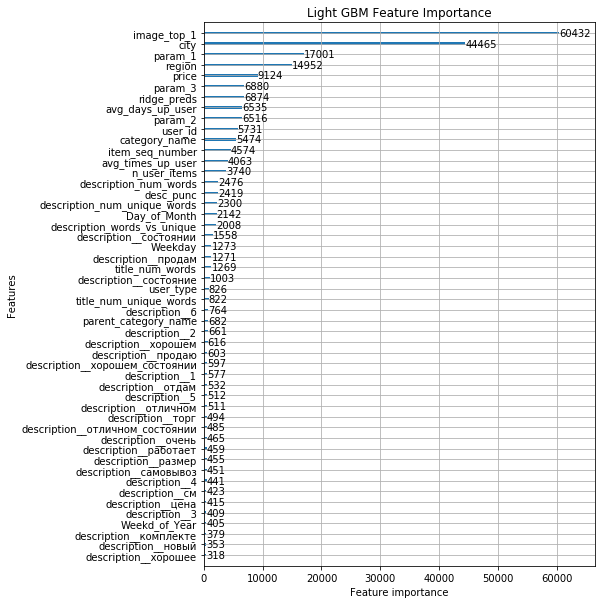

In [37]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()
plt.savefig('feature_import.png')

In [38]:
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv(subpath+"new_Feats_lgsub.csv",index=True,header=True)

/home/vishy/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:448: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')
